In [176]:
import pandas as pd
from collections import namedtuple
import ast
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict

In [195]:
fastq_file = "data_samples/new_sequencing_may2025/reads/barcode06.fastq"

In [196]:
df = pd.read_csv('data_samples/new_sequencing_may2025/positions/barcode06/fuzzy_matches/barcode06_primer_positions.csv')

In [179]:
df.head(20)

,Sequence
0,"[SequenceMatch(seq_id=0, query_name='Left|R', ..."
1,"[SequenceMatch(seq_id=1, query_name='RCLeft|L'..."
2,"[SequenceMatch(seq_id=2, query_name='Left|L', ..."
3,"[SequenceMatch(seq_id=3, query_name='RCRight|L..."
4,"[SequenceMatch(seq_id=4, query_name='Right|R',..."
5,"[SequenceMatch(seq_id=5, query_name='RCLeft|L'..."
6,"[SequenceMatch(seq_id=6, query_name='RCLeft|L'..."
7,"[SequenceMatch(seq_id=7, query_name='Left|R', ..."
8,"[SequenceMatch(seq_id=8, query_name='Left|R', ..."
9,"[SequenceMatch(seq_id=9, query_name='Right|L',..."


In [197]:
df.shape

(8355, 1)

In [198]:
SequenceMatch = namedtuple("SequenceMatch", ["seq_id", "query_name", "position", "length", "score"])

In [199]:
# Safely evaluate using known symbols only
allowed_globals = {"SequenceMatch": SequenceMatch}

# Convert strings to list of SequenceMatch objects
df["parsed"] = df["Sequence"].apply(lambda s: eval(s, allowed_globals))

In [200]:
df.head()

,Sequence,parsed
0,[],[]
1,"[SequenceMatch(seq_id=1, query_name='RCRight|L...","[(1, RCRight|L, 8, 10, 1.0), (1, RCRight|R, 18..."
2,[],[]
3,"[SequenceMatch(seq_id=3, query_name='RCLeft|L'...","[(3, RCLeft|L, 1, 10, 1.0), (3, RCRight|L, 14,..."
4,"[SequenceMatch(seq_id=4, query_name='Left|R', ...","[(4, Left|R, 23, 10, 1.0), (4, Right|L, 32, 10..."


In [201]:
primers = [('RCRight|L', 'RCRight|R'),
          ('Right|L', 'Right|R'),
          ('Left|L', 'Left|R'),
          ('RCLeft|L', 'RCLeft|R')]

In [202]:
# Step 4: Collect distances by query pair
pairwise_distances = defaultdict(list)

for matches in df["parsed"]:
    for i in range(len(matches) - 1):
        a = matches[i]
        b = matches[i + 1]
        distance = b.position - (a.position + a.length)
        pair = (a.query_name, b.query_name)
        pairwise_distances[pair].append(distance)


In [203]:
primers_pairwise_distances = defaultdict(list)
for key, values in pairwise_distances.items():
    if key in primers:
        primers_pairwise_distances[key] = values

In [204]:
pairwise_distances = {k: v for k, v in pairwise_distances.items() if k not in primers}

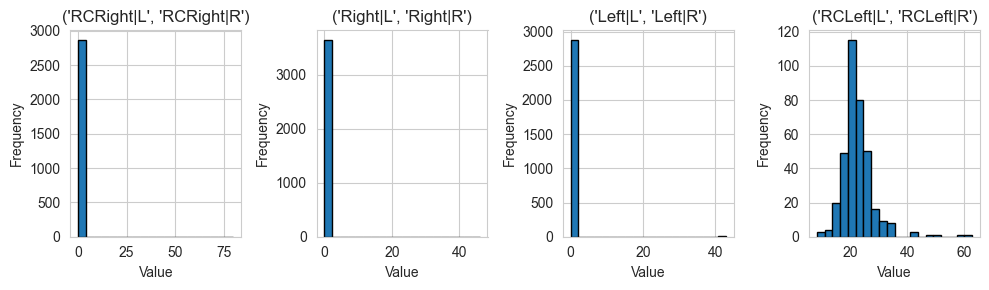

In [205]:
n = len(primers_pairwise_distances)
cols = 4
rows = 1

fig, axes = plt.subplots(rows, cols, figsize=(10, 3 * rows))

for ax, (key, values) in zip(axes.flatten(), primers_pairwise_distances.items()):
    ax.hist(values, bins=20, edgecolor="black")
    ax.set_title(str(key))
    ax.set_xlabel("Value")
    ax.set_ylabel("Frequency")

# Hide unused subplots (if any)
for ax in axes.flatten()[len(primers_pairwise_distances):]:
    ax.axis("off")

plt.tight_layout()
plt.show()

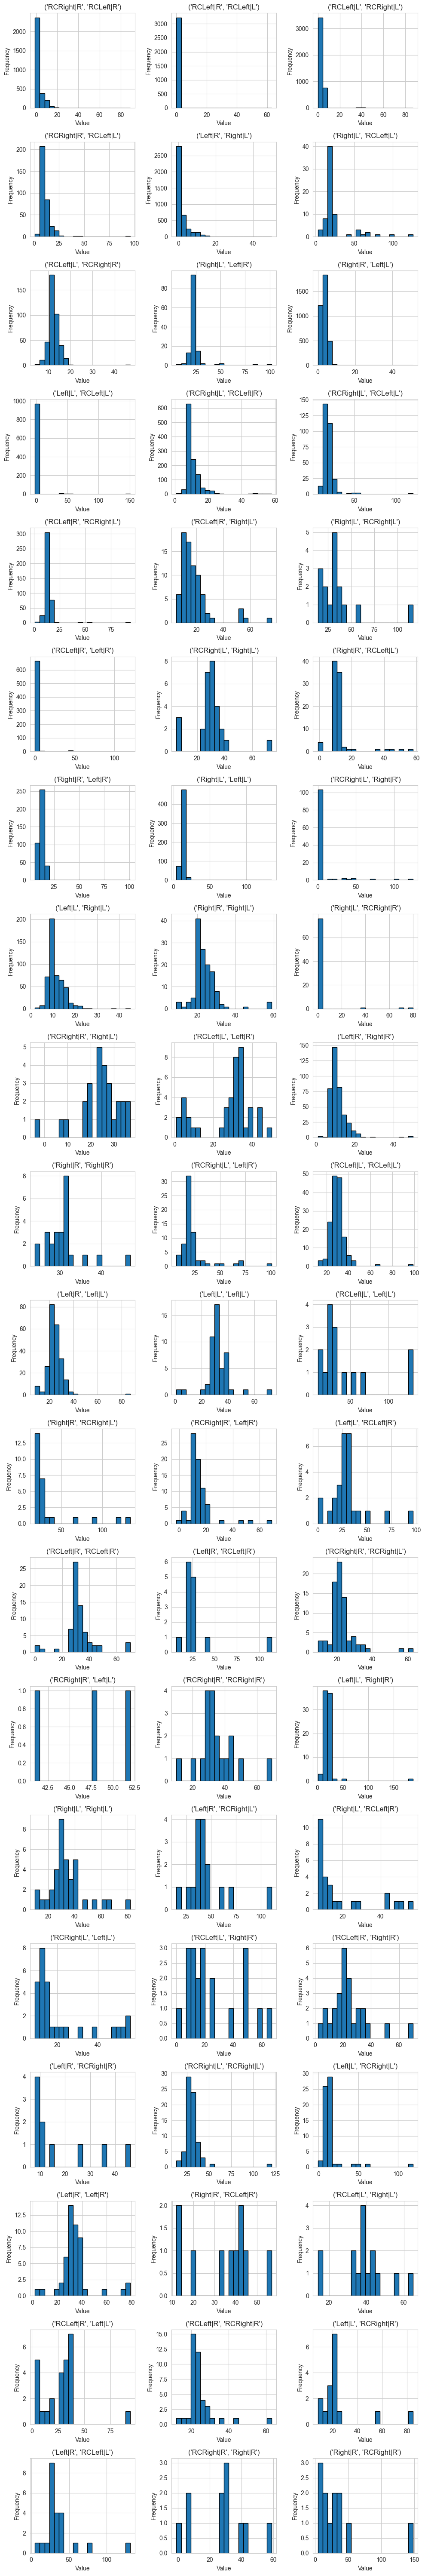

In [206]:
n = len(pairwise_distances)
cols = 3
rows = (n + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(10, 3 * rows))

for ax, (key, values) in zip(axes.flatten(), pairwise_distances.items()):
    if key not in primers:
        ax.hist(values, bins=20, edgecolor="black")
        ax.set_title(str(key))
        ax.set_xlabel("Value")
        ax.set_ylabel("Frequency")
        
plt.tight_layout()
plt.show()

In [207]:
representative_junctions = [('RCLeft|L', 'RCRight|L'),
          ('Left|R', 'Right|L'),
          ('Right|R', 'Left|L'),
          ('RCRight|R', 'RCLeft|R'),
          ('RCLeft|R', 'RCLeft|L')]

In [208]:
junctions_pairwise_distances = {k: v for k, v in pairwise_distances.items() if k in representative_junctions}

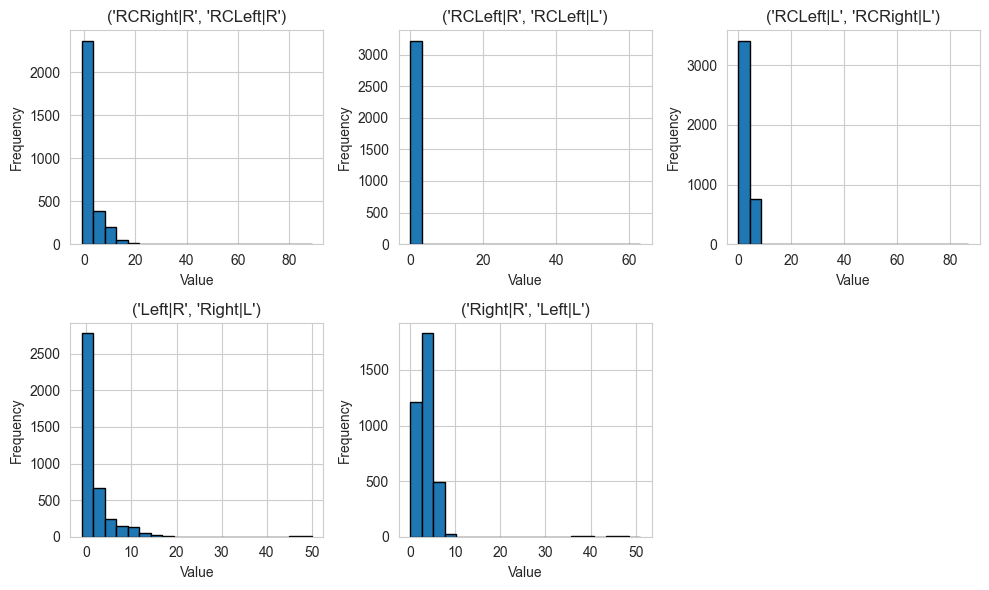

In [209]:
n = len(junctions_pairwise_distances)
cols = 3
rows = 2

fig, axes = plt.subplots(rows, cols, figsize=(10, 3 * rows))

for ax, (key, values) in zip(axes.flatten(), junctions_pairwise_distances.items()):
    ax.hist(values, bins=20, edgecolor="black")
    ax.set_title(str(key))
    ax.set_xlabel("Value")
    ax.set_ylabel("Frequency")

# Hide unused subplots (if any)
for ax in axes.flatten()[len(junctions_pairwise_distances):]:
    ax.axis("off")

plt.tight_layout()
plt.show()

In [210]:
def remove_duplicates(dict_list):
    seen = set()
    unique_dicts = []
    for d in dict_list:
        # Convert dict to a hashable form (tuple of sorted key-value pairs)
        dict_tuple = tuple(sorted(d.items()))
        if dict_tuple not in seen:
            seen.add(dict_tuple)
            unique_dicts.append(d)
    return unique_dicts

In [211]:
def filter_by_neighbour_distances_df(df, rules, min_distance_threshold, max_distance_threshold, include=False):
    filtered_sequences = []

    for _, row in df.iterrows():
        matches = row["parsed"]
        if not matches or len(matches) <= 2:
            continue

        matches.sort(key=lambda match: match.position)

        for rule in rules:
            start = rule['start']
            end = rule['end']
            orientation = rule['orientation']

            for i in range(len(matches) - 1):
                if matches[i].query_name == start and matches[i+1].query_name == end:
                    distance = matches[i+1].position - (matches[i].position + matches[i].length)
                    if min_distance_threshold <= distance <= max_distance_threshold:
                        filtered_sequences.append({
                            'id': matches[i].seq_id,
                            'start_pos': matches[i].position + matches[i].length if not include else matches[i].position,
                            'end_pos': matches[i+1].position if not include else matches[i+1].position + matches[i+1].length,
                            'orientation': orientation
                        })

    return remove_duplicates(filtered_sequences)


In [212]:
from Bio import SeqIO
# from sklearn.metrics import silhouette_score
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq

def trim_sequences(input_fastq: str, output_fastq: str, filtered: list):

    selected_records = []
    n_records = 0
    unique_id_counter = 1  # Counter for generating unique numeric IDs


    for index, record in enumerate(SeqIO.parse(input_fastq, "fastq")):
        n_records += 1
        for rec in filtered:
            if rec['id'] == index:  # Match sequence index
                trimmed_seq = record.seq[rec['start_pos']:rec['end_pos']]
                if len(str(trimmed_seq)) >= rec['end_pos'] - rec['start_pos']:
                    trimmed_qual = record.letter_annotations["phred_quality"][rec['start_pos']:rec['end_pos']]

                    # Ensure it's a Seq object
                    seq_obj = Seq(trimmed_seq)

                    # Then reverse complement if needed
                    seq_final = seq_obj if rec['orientation'] == 'direct' else seq_obj.reverse_complement()

                    # Create a new FASTQ record
                    new_record = SeqRecord(
                        seq_final,
                        id=str(unique_id_counter),
                        description="",
                        letter_annotations={"phred_quality": trimmed_qual}  # Preserve quality scores
                    )

                    selected_records.append(new_record)
                    unique_id_counter += 1

    print(f'Selected records: {len(selected_records)}')
    print(f'Number of records: {n_records}')
    print(selected_records)

    # Save filtered sequences in FASTQ format
    with open(output_fastq, 'w') as outfile:
        SeqIO.write(selected_records, outfile, "fastq")

In [213]:
rules = [{"start": "RCLeft|L", "end": "RCRight|L", "orientation": "direct"}]
dir = 'RCLeft-RCRight'
title = 'rcleft-rcright'
barcode = '06'
for i in range(0,6):
    filtered = filter_by_neighbour_distances_df(df[['parsed']], rules, i, i, True)
    output_fastq_path = f"data_samples/new_sequencing_may2025/positions/barcode{barcode}/fuzzy_matches/junctions/{dir}/barcode{barcode}_trimmed_{title}_{i}.fastq"
    trim_sequences(fastq_file, output_fastq_path, filtered)
    with open(f'data_samples/new_sequencing_may2025/positions/barcode{barcode}/fuzzy_matches/junctions/{dir}/barcode{barcode}_trimmed_{title}_{i}.fasta', "w") as fasta_handle:
        SeqIO.write(SeqIO.parse(output_fastq_path, "fastq"), fasta_handle, "fasta")

Selected records: 5
Number of records: 8355
[SeqRecord(seq=Seq('ATCCATGAAGTCGTGCTAA'), id='1', name='<unknown name>', description='', dbxrefs=[]), SeqRecord(seq=Seq('ATCCATGAAGTCGTGCTAAG'), id='2', name='<unknown name>', description='', dbxrefs=[]), SeqRecord(seq=Seq('ATCCATGAAGTCGTGCTAAG'), id='3', name='<unknown name>', description='', dbxrefs=[]), SeqRecord(seq=Seq('TCCATGAAGTCGTGCTAAG'), id='4', name='<unknown name>', description='', dbxrefs=[]), SeqRecord(seq=Seq('ATCCATGAATCGTGCTAA'), id='5', name='<unknown name>', description='', dbxrefs=[])]
Selected records: 1454
Number of records: 8355
[SeqRecord(seq=Seq('ATCCATGAAGCTCGTGCTAAG'), id='1', name='<unknown name>', description='', dbxrefs=[]), SeqRecord(seq=Seq('ATCCATGAAGATCGTGCTAAG'), id='2', name='<unknown name>', description='', dbxrefs=[]), SeqRecord(seq=Seq('ATCCATGAAGATCGTGCTAAG'), id='3', name='<unknown name>', description='', dbxrefs=[]), SeqRecord(seq=Seq('ATCCATGAAGATCGTGCTAAG'), id='4', name='<unknown name>', descripti

In [154]:
rules = [{"start": "Right|R", "end": "Left|L", "orientation": "direct"}]
filtered = filter_by_neighbour_distances_df(df[['parsed']], rules, 2, 2, True)

In [155]:
output_fastq_path = "data_samples/new_sequencing_may2025/positions/fuzzy_matches/junctions/Right-Left/barcode14_trimmed_right_left_1.fastq"
trim_sequences(fastq_file, output_fastq_path, filtered)
with open('data_samples/new_sequencing_may2025/positions/fuzzy_matches/junctions/Right-Left/barcode14_trimmed_right_left_1.fasta', "w") as fasta_handle:
    SeqIO.write(SeqIO.parse(output_fastq_path, "fastq"), fasta_handle, "fasta")

Selected records: 249
Number of records: 4362
[SeqRecord(seq=Seq('CTTAGCACGATCTTCATGGAT'), id='1', name='<unknown name>', description='', dbxrefs=[]), SeqRecord(seq=Seq('CTTAGCACGATCTTCATGGAT'), id='2', name='<unknown name>', description='', dbxrefs=[]), SeqRecord(seq=Seq('CTTAGCACGAACTTCATGGAT'), id='3', name='<unknown name>', description='', dbxrefs=[]), SeqRecord(seq=Seq('CTTAGCACGATCTTCATGGAT'), id='4', name='<unknown name>', description='', dbxrefs=[]), SeqRecord(seq=Seq('CTTAGCACGATCTTCATGGAT'), id='5', name='<unknown name>', description='', dbxrefs=[]), SeqRecord(seq=Seq('CTTAGCACGATCTTCATGGAT'), id='6', name='<unknown name>', description='', dbxrefs=[]), SeqRecord(seq=Seq('CTTAGCACGATCTTCATGGAT'), id='7', name='<unknown name>', description='', dbxrefs=[]), SeqRecord(seq=Seq('CTTAGCACGATCTTCATGGAT'), id='8', name='<unknown name>', description='', dbxrefs=[]), SeqRecord(seq=Seq('CTTAGCACGATCTTCATGGAT'), id='9', name='<unknown name>', description='', dbxrefs=[]), SeqRecord(seq=Seq

In [14]:
# Step 5: Aggregate statistics
stats = []
for pair, distances in pairwise_distances.items():
    arr = np.array(distances)
    stats.append({
        "from": pair[0],
        "to": pair[1],
        "count": len(arr),
        "mean": np.mean(arr),
        "std": np.std(arr),
        "min": np.min(arr),
        "max": np.max(arr),
        "median": np.median(arr)
    })

In [15]:
stats_df = pd.DataFrame(stats)
stats_df = stats_df.sort_values(by=["from", "to"]).reset_index(drop=True)


In [16]:
stats_df

,from,to,count,mean,std,min,max,median
0,Left/l,Left/l,81,34.320988,9.164919,23,73,32.0
1,Left/l,Left/r,2554,0.359436,4.775789,0,133,0.0
2,Left/l,RCLeft/l,33,32.575758,13.595967,7,77,29.0
3,Left/l,RCLeft/r,1515,-1.395380,5.169227,-2,79,-2.0
4,Left/l,RCRight/l,93,11.505376,6.624529,-1,48,11.0
...,...,...,...,...,...,...,...,...
59,Right/r,RCLeft/r,164,10.829268,7.186208,-1,72,11.0
60,Right/r,RCRight/l,41,24.634146,16.105984,2,86,22.0
61,Right/r,RCRight/r,13,23.461538,17.796350,3,77,15.0
62,Right/r,Right/l,157,24.503185,11.039376,5,89,22.0


In [66]:
stats_df[(stats_df['min'] >= -3) & (stats_df['min'] <= 30)]

,from,to,count,mean,std,min,max,median
0,Left/l,Left/l,81,34.320988,9.164919,23,73,32.0
1,Left/l,Left/r,2554,0.359436,4.775789,0,133,0.0
2,Left/l,RCLeft/l,33,32.575758,13.595967,7,77,29.0
3,Left/l,RCLeft/r,1515,-1.395380,5.169227,-2,79,-2.0
4,Left/l,RCRight/l,93,11.505376,6.624529,-1,48,11.0
...,...,...,...,...,...,...,...,...
59,Right/r,RCLeft/r,164,10.829268,7.186208,-1,72,11.0
60,Right/r,RCRight/l,41,24.634146,16.105984,2,86,22.0
61,Right/r,RCRight/r,13,23.461538,17.796350,3,77,15.0
62,Right/r,Right/l,157,24.503185,11.039376,5,89,22.0


In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

In [12]:
glued_df = stats_df[(stats_df['min'] >= -3) & (stats_df['min'] <= 30)]

In [13]:
# Create pivot table
pivot = glued_df.pivot(index='from', columns='to', values='count')

In [14]:
# Fill missing values with 0 or another suitable value (e.g., np.nan)
pivot = pivot.fillna(0)

In [15]:
pivot.shape

(8, 8)

In [16]:
pivot

to,Left/l,Left/r,RCLeft/l,RCLeft/r,RCRight/l,RCRight/r,Right/l,Right/r
from,,,,,,,,
Left/l,30.0,1191.0,4.0,6.0,3.0,1.0,204.0,44.0
Left/r,89.0,20.0,17.0,6.0,1.0,0.0,1138.0,127.0
RCLeft/l,0.0,0.0,15.0,1068.0,107.0,8.0,0.0,0.0
RCLeft/r,0.0,0.0,87.0,49.0,1199.0,65.0,0.0,2.0
RCRight/l,0.0,1.0,399.0,220.0,28.0,643.0,0.0,1.0
RCRight/r,1.0,0.0,624.0,86.0,19.0,0.0,1.0,0.0
Right/l,188.0,53.0,1.0,0.0,0.0,1.0,22.0,1158.0
Right/r,1135.0,117.0,0.0,2.0,1.0,0.0,35.0,12.0


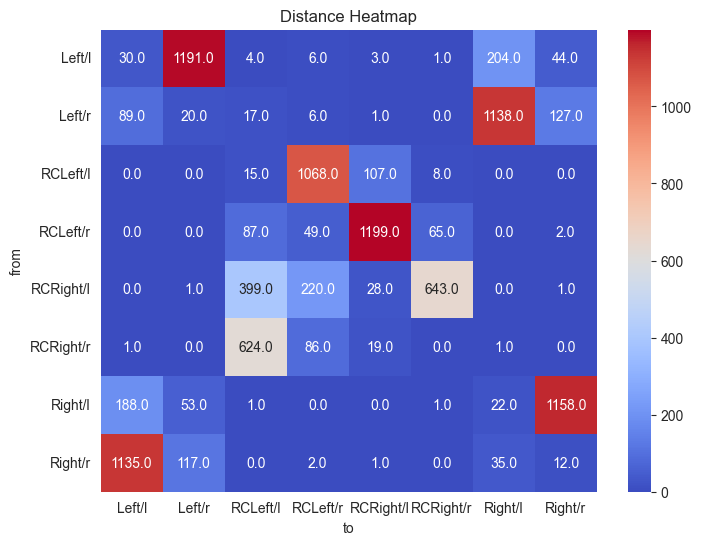

In [17]:
# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(pivot, annot=True, cmap='coolwarm', fmt='.1f')
plt.title("Distance Heatmap")
plt.show()

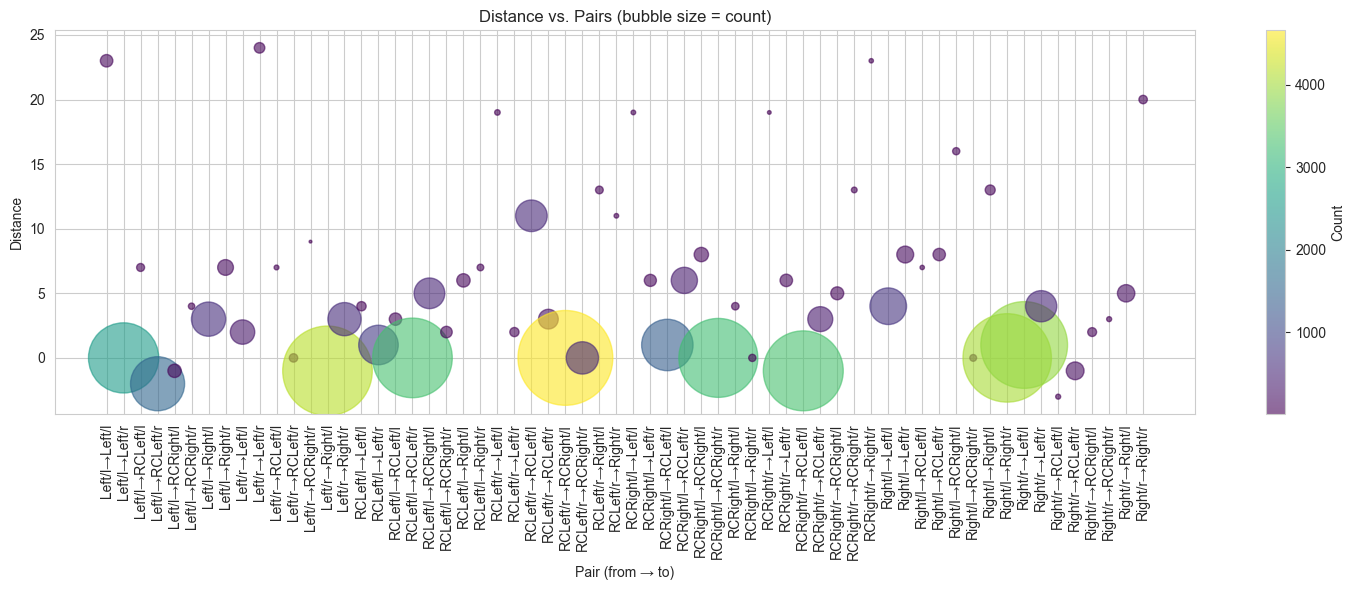

In [80]:
%plt.figure(figsize=(15, 6))
scatter = plt.scatter(glued_df['from'] + '→' + glued_df['to'], glued_df['min'], s=glued_df['count'], alpha=0.6, c=glued_df['count'], cmap='viridis')
plt.colorbar(scatter, label='Count')
plt.xlabel('Pair (from → to)')
plt.ylabel('Distance')
plt.title('Distance vs. Pairs (bubble size = count)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [28]:
stats_df[(stats_df['median'] >= 46) & (stats_df['median'] <= 66) & (stats_df['count'] >= 5)]

,from,to,count,mean,std,min,max,median
3,Left/l,RCLeft/r,14,74.071429,40.465972,41,151,50.5
12,Left/r,RCRight/l,8,57.375000,22.203251,41,111,46.0
14,Left/r,Right/l,14,42.642857,12.361271,-1,50,46.0
17,RCLeft/l,Left/r,11,56.454545,31.116683,3,120,46.0
22,RCLeft/l,Right/l,5,58.200000,8.997778,52,76,54.0
24,RCLeft/r,Left/l,5,84.400000,37.253725,42,132,66.0
31,RCLeft/r,Right/r,5,54.200000,7.359348,48,67,49.0
32,RCRight/l,Left/l,5,52.400000,3.200000,48,56,52.0
34,RCRight/l,RCLeft/l,11,47.000000,12.489996,9,58,49.0
35,RCRight/l,RCLeft/r,6,62.666667,26.284765,45,121,51.5
